In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# 1. Chuẩn bị Data

In [ ]:
!pip install unrar

%cd /content/drive/MyDrive/Safe-Drive/data
!unrar x "/content/drive/MyDrive/Safe-Drive/data/raw_data.rar"

In [ ]:
# 2. Tạo thư mục data/split_data và chạy lệnh chia train test
import os
import glob
import random
import shutil

raw_data_path = "/content/drive/MyDrive/Safe-Drive/data/raw_data/images"
train_data_path = "/content/drive/MyDrive/Safe-Drive/data/split_data/train"
test_data_path = "/content/drive/MyDrive/Safe-Drive/data/split_data/test"

if not os.path.exists("/content/drive/MyDrive/Safe-Drive/data/split_data/"):
  os.mkdir("/content/drive/MyDrive/Safe-Drive/data/split_data/")
  
try:
  shutil.rmtree(train_data_path)
  shutil.rmtree(test_data_path)
except:
  pass

os.mkdir(train_data_path)
os.mkdir(test_data_path)

total_files = glob.glob(raw_data_path + "/*.jpg")
print("Sample file = ", total_files[0])
print("Total file = ", len(total_files))

indices = list(range(len(total_files)))
train_indices = random.sample(indices, k = int(len(total_files)*0.9))
print("Total train file = ", len(train_indices))

for i in indices:
   
    if (i in train_indices):
        # Copy to train
        shutil.copy(total_files[i], train_data_path + total_files[i].replace(raw_data_path,""))
        shutil.copy(total_files[i].replace("images","labels").replace(".jpg",".xml"),
                    train_data_path + total_files[i].replace(raw_data_path, "").replace(".jpg",".xml"))
    else:
        # Copy to test
        shutil.copy(total_files[i], test_data_path + total_files[i].replace(raw_data_path, ""))
        shutil.copy(total_files[i].replace("images", "labels").replace(".jpg", ".xml"),
                    test_data_path + total_files[i].replace(raw_data_path, "").replace(".jpg",".xml"))

Sample file =  /content/drive/MyDrive/Safe-Drive/data/raw_data/images/img_1.jpg
Total file =  3669
Total train file =  3302


In [ ]:
# 3.Convert XML label sang CSV. File CSV lưu trong thư mục split_data
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET


def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

for directory in ['train','test']:
        image_path = os.path.join('/content/drive/MyDrive/Safe-Drive/data/split_data/{}'.format(directory))
        xml_df = xml_to_csv(image_path)
        xml_df.to_csv('/content/drive/MyDrive/Safe-Drive/data/split_data/{}_labels.csv'.format(directory), index=None)
        print('Successfully converted xml to csv.')

Successfully converted xml to csv.
Successfully converted xml to csv.


In [2]:
# 4. Tải TF Object Detection APi vào thư mục models
%cd /content/drive/MyDrive/Safe-Drive
!git clone https://github.com/tensorflow/models.git

/content/drive/MyDrive/Safe-Drive
Cloning into 'models'...
remote: Enumerating objects: 77720, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 77720 (delta 50), reused 88 (delta 47), pack-reused 77621
Receiving objects: 100% (77720/77720), 593.35 MiB | 17.68 MiB/s, done.
Resolving deltas: 100% (55209/55209), done.
Checking out files: 100% (3175/3175), done.


In [3]:
# 5. Compile the protos -  
# Protocol Buffers (Protobuf) is a free and open-source cross-platform data format used to serialize structured data.
%cd /content/drive/MyDrive/Safe-Drive/models/research
!protoc object_detection/protos/*.proto --python_out=.

/content/drive/MyDrive/Safe-Drive/models/research


In [4]:
# 6. Cài dặt API
%cd /content/drive/MyDrive/Safe-Drive/models/research
!cp object_detection/packages/tf2/setup.py . 
!python -m pip install .

/content/drive/MyDrive/Safe-Drive/models/research
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/drive/MyDrive/Safe-Drive/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 10.9 MB 54.4 MB/s 
     |████████████████████████████████| 352 kB 72.8 MB/s 
     |████████████████████████████████| 2.2 MB 56.3 MB/s 
     |████████████████████████████████| 25.0 MB 1.4 MB/s 
     |████████████████████████████████| 67 kB 5.3 MB/s 
     |████████████████████████████████| 116 kB 72.9 MB/s 
     |████████████████████████████████| 636 kB 

In [ ]:
# 7. Test API
!python object_detection/builders/model_builder_tf2_test.py

In [6]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 18 not upgraded.
Need to get 430 MB of archives.
After this operation, 3,139 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 14s (31.5 MB/s)
(Reading database ... 159447 files and directories currently installed.)
Removing libcudnn8-dev (8.0.5.39-1+cuda11.1) ...
(Reading database ... 159425 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb ...
Unpacking libcudnn8 (8.1.0.77-1+

In [7]:
%cd /content/drive/MyDrive/Safe-Drive/models/research
!git clone https://github.com/thangnch/MiAI_SSD_TF2

/content/drive/MyDrive/Safe-Drive/models/research
Cloning into 'MiAI_SSD_TF2'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 20 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (20/20), done.


In [8]:
# 8. CSV to TFRecord. With help from MiAI git hub
import os
%cd /content/drive/MyDrive/Safe-Drive/models/research
# !git clone https://github.com/thangnch/MiAI_SSD_TF2
!cp MiAI_SSD_TF2/generate_tfrecord.py .
# !cp MiAI_SSD_TF2/label_map.txt /content/drive/MyDrive/Safe-Drive/data
if not os.path.exists("/content/drive/MyDrive/Safe-Drive/data/tfrecord_data/"):
  os.mkdir("/content/drive/MyDrive/Safe-Drive/data/tfrecord_data/")

!python generate_tfrecord.py --image_dir=/content/drive/MyDrive/Safe-Drive/data/split_data/train --csv_input=/content/drive/MyDrive/Safe-Drive/data/split_data/train_labels.csv --output_path=/content/drive/MyDrive/Safe-Drive/data/tfrecord_data/train.record 
!python generate_tfrecord.py --image_dir=/content/drive/MyDrive/Safe-Drive/data/split_data/test --csv_input=/content/drive/MyDrive/Safe-Drive/data/split_data/test_labels.csv --output_path=/content/drive/MyDrive/Safe-Drive/data/tfrecord_data/test.record 

/content/drive/MyDrive/Safe-Drive/models/research
2022-10-05 14:06:37.154076: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-05 14:06:37.321226: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-05 14:06:37.995713: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2022-10-05 14:06:37.995812: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so

In [9]:
# 9. Download pretrain and config
import os
if not os.path.exists("/content/drive/MyDrive/Safe-Drive/pretrained"):
  os.mkdir("/content/drive/MyDrive/Safe-Drive/pretrained")

%cd /content/drive/MyDrive/Safe-Drive/pretrained
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
# Unzip
!tar -xzvf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

# Config pipeline.config, label_map.txt if needed

/content/drive/MyDrive/Safe-Drive/pretrained
--2022-10-05 14:14:42--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.16.128, 2607:f8b0:4004:c17::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.16.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M  83.0MB/s    in 0.2s    

2022-10-05 14:14:43 (83.0 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’ saved [20515344/20515344]

ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint

In [ ]:
# Upload label file object-detection.txt to data folder
%cd /content/drive/MyDrive/Safe-Drive/models
!pip install -r /content/drive/MyDrive/Safe-Drive/models/research/MiAI_SSD_TF2/setup.txt
!pip install --upgrade opencv-python

In [ ]:
# %cd /content/drive/MyDrive/Safe-Drive/models/research
# !cp object_detection/packages/tf2/setup.py . 
# !python -m pip install .

In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 18 not upgraded.
Need to get 430 MB of archives.
After this operation, 3,139 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 8s (52.6 MB/s)
(Reading database ... 159447 files and directories currently installed.)
Removing libcudnn8-dev (8.0.5.39-1+cuda11.1) ...
(Reading database ... 159425 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb ...
Unpacking libcudnn8 (8.1.0.77-1+c

In [11]:
# Train
%cd /content/drive/MyDrive/Safe-Drive/models/research
%cp /content/drive/MyDrive/Safe-Drive/models/research/object_detection/model_main_tf2.py .

#train 
!python model_main_tf2.py \
--pipeline_config_path=/content/drive/MyDrive/Safe-Drive/pipeline.config \
--model_dir=/content/drive/MyDrive/Safe-Drive/output_model --alsologtostderr --num_train_steps=10000

/content/drive/MyDrive/Safe-Drive/models/research
2022-10-05 14:17:20.221887: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-05 14:17:20.387754: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-05 14:17:21.160652: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2022-10-05 14:17:21.160769: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so

In [15]:
# Export model
%cd /content/drive/MyDrive/Safe-Drive/models/research
%cp /content/drive/MyDrive/Safe-Drive/models/research/object_detection/exporter_main_v2.py .

!python exporter_main_v2.py \
--trained_checkpoint_dir='/content/drive/MyDrive/Safe-Drive/output_model' \
--pipeline_config_path='/content/drive/MyDrive/Safe-Drive/pipeline.config' \
--output_directory='/content/drive/MyDrive/Safe-Drive/export_model'

/content/drive/MyDrive/Safe-Drive/models/research
2022-10-05 14:33:07.239643: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-05 14:33:07.971794: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2022-10-05 14:33:07.971899: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2022-10-05 14:33:07.971916: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the

In [ ]:
!pip install tensorflow==2.8.0

In [ ]:
!pip install -r /content/drive/MyDrive/Safe-Drive/models/research/MiAI_SSD_TF2/setup.txt


In [16]:
import io
import os
import scipy.misc
import numpy as np
import six
import time
import glob
from IPython.display import display

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

%cd /content/drive/MyDrive/Safe-Drive/models/research/

import tensorflow as tf
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

#Load model
tf.keras.backend.clear_session()
model = tf.saved_model.load("/content/drive/MyDrive/Safe-Drive/export_model/saved_model")

/content/drive/MyDrive/Safe-Drive/models/research


In [17]:
# Các hàm inference

import cv2
def run_inference_for_single_image(model, image):
  
  image = np.asarray(image)
  input_tensor = tf.convert_to_tensor(image)
  input_tensor = input_tensor[tf.newaxis,...]

  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  if 'detection_masks' in output_dict:
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

def load_image_into_numpy_array(path):
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

/content/drive/MyDrive/Safe-Drive/models/research
Done load image 
Done inference
Done draw on image 


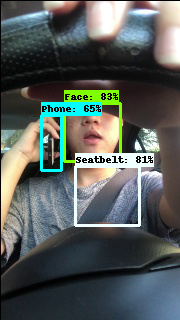

In [18]:
%cd /content/drive/MyDrive/Safe-Drive/models/research
category_index = label_map_util.create_category_index_from_labelmap("/content/drive/MyDrive/Safe-Drive/data/label_map.txt", use_display_name=True)

# image_path = '/content/drive/MyDrive/Safe-Drive/data/split_data/test/img_1413.jpg'
image_path = '/content/drive/MyDrive/Safe-Drive/data/split_data/test/img_1003.jpg'
image_np = load_image_into_numpy_array(image_path)
print("Done load image ")
# image_np = cv2.resize(image_np, dsize=(224,224), fx=1, fy=1)

# image_np = cv2.resize(image_np, dsize=None, fx=1, fy=1)
output_dict = run_inference_for_single_image(model, image_np)
print("Done inference")
vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks_reframed', None),
    use_normalized_coordinates=True,
    line_thickness=3)
# for i in range(len(output_dict['detection_classes'])):
#   if output_dict['detection_classes'][i] == 2:
#     print(output_dict['detection_boxes'][i], ':',i)

print("Done draw on image ")
display(Image.fromarray(image_np))